# Tarea Semanal 5: Simulación de un ADC (cuantización, muestreo y alias)
## Magdalena Noé
Se simulará un ADC incluyendo capacidad de muestrear a $f_s$ [Hz], con una señal analogica muestreada a $f′_S=k_O.f_S$, siendo $k_O$ el factor de sobremuestreo. Se adoptará una potencia de ruido analógico igual al ruido de cuantización.

Primero se generarán dichas señales, con y sin oversampling, analizando sus diferencias.

Luego se aplicará un filtro pasabajos a la señal con oversampling, eliminando el alias, para apreciar la ventaja en definición que trae esta práctica. Por otro lado se generarán 4 casos en donde no se usa el filtro pasabajos de forma correcta, demostrando el efecto alias y las consecuencias que tiene en la señal.

- $f_c > fs/2$:     Parte de los valores superan el ancho de banda original, superponiendose entre sí (efecto alias)
- $f_c << fs/2$:    Se filtra por debajo del ancho de banda original, perdiendo informacion de la señal innecesariamente
- $f_c < fs/2$ pero N=1:    Se respeta el límite de de Nyquist pero el filtro es de orden bajo (ligero efecto alias)
- $∄$:      La señal no se filtra (máximo efecto alias)

### Librerías

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
import scipy.signal as sig

from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()

#### Parámetros generales

In [ ]:
fs = 1000       # Frecuencia de muestreo [Hz]
ko = 10          # Factor de sobremuestreo
fs_os = fs * ko # Frec de muestreo con oversamp
ts_os = 1/fs_os
N = fs          # cantidad de muestras
N_os = N * ko   # cantidad de muestras con oversamp
fo = fs/N # [Hz]

Vmax = np.sqrt(2) #[Volts]
df_os = fs_os/N_os # resolución espectral

# RUIDO #
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]

#### Generación, contaminación y cuantificación de la señal

In [121]:
tt = np.arange(N) / fs
s = Vmax * np.sin(tt*2*np.pi*fo)

tt_os = np.arange(N_os) / fs_os
s_os = Vmax * np.sin(tt_os*2*np.pi*fo)

n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido
sr = s + n
srq = np.round(sr / q) * q # Cuantizacion
nq = srq - sr

n_os = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N_os) # Ruido
sr_os = s_os + n_os
srq_os = np.round(sr_os / q) * q # Cuantizacion
nq_os = srq_os - sr_os # Error de cuantizacion


Graficamos las señales para apreciar sus diferencias

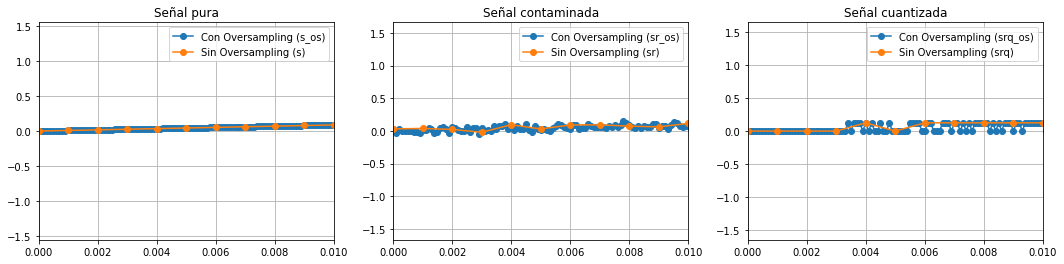

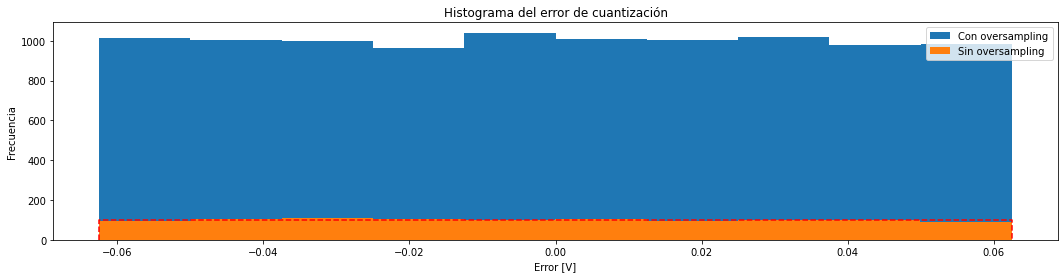

In [148]:
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.plot(tt_os, s_os, 'o-', label='Con Oversampling (s_os)')
plt.plot(tt, s, 'o-', label='Sin Oversampling (s)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal pura")

plt.subplot(1,3,2)
plt.plot(tt_os, sr_os, 'o-', label='Con Oversampling (sr_os)')
plt.plot(tt, sr, 'o-', label='Sin Oversampling (sr)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal contaminada")

plt.subplot(1,3,3)
plt.plot(tt_os, srq_os, 'o-', label='Con Oversampling (srq_os)')
plt.plot(tt, srq, 'o-', label='Sin Oversampling (srq)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal cuantizada")
plt.show()

plt.figure(4, figsize=(18, 4))
bins = 10
plt.hist(nq_os, bins=bins, label="Con oversampling")
plt.hist(nq, bins=bins, label="Sin oversampling")
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title("Histograma del error de cuantización")
plt.xlabel("Error [V]"); plt.ylabel("Frecuencia"); plt.legend(); plt.show()

## Filtrado del alias apropiado
A continuación se filtra la señal con oversampling cuantificada con un filtro butter de cuarto grado y una frecuencia de corte que respeta el límite de Nyquist. Luego se decimara la misma para "eliminar" el efecto oversampling, tomando un valor de cada $k_o$ valores

0.1


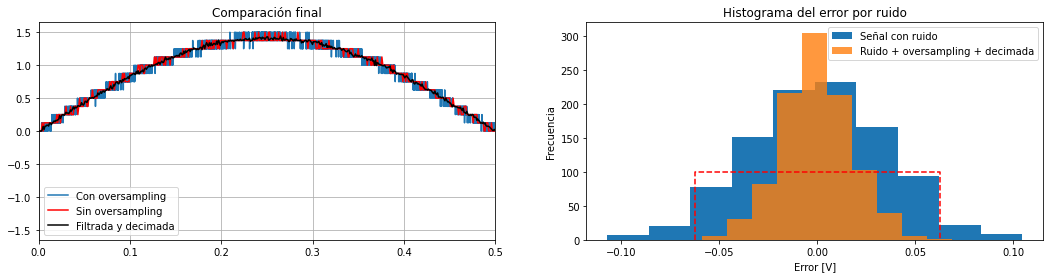

In [266]:
orden_filtro = 4
fc = fs/2 
f_nyquist = fs_os/2

Wn = fc/f_nyquist
print(Wn)

coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_decimada = s_filtrada[::ko]
tt_decimada = tt_os[::ko]

n_dec = s_decimada - s # Error con señal analogica
n_r = sr - s # Error con señal analogica

plt.figure(4, figsize=(18, 4))
plt.subplot(1,2,1)
plt.plot(tt_os, srq_os, label='Con oversampling')
plt.plot(tt, srq, label='Sin oversampling', color="red")
plt.plot(tt_decimada, s_decimada, label='Filtrada y decimada', color="black")
plt.title("Comparación final"); plt.legend(); plt.grid(); plt.xlim(0, 0.5)

plt.subplot(1,2,2)
bins = 10
plt.hist(n_r, bins=bins, label="Señal con ruido")
plt.hist(n_dec, bins=bins, alpha=0.8, label="Ruido + oversampling + decimada")
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title("Histograma del error por ruido")
plt.xlabel("Error [V]"); plt.ylabel("Frecuencia"); plt.legend(); 
plt.show()


## Experimentación de los filtros
En el caso anterior se respetaba el límite de Nyquist para crear el filtro ideal, donde se evita el efecto aliasing pero se pierde la menor cantidad de la señal posible.
Ahora experimentamos con los 4 casos definidos al inicio.

##### Caso 1: $f_c > fs/2$

In [385]:
#Wn_aliasing = (5*fc)/f_nyquist
Wn_aliasing = 0.999
orden_filtro = 4
# Filtrado
coef_num, coef_den = butter(orden_filtro, Wn_aliasing)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_1 = s_filtrada[::ko]
tt_1 = tt_os[::ko]
n_1 = s_1 - s # Error con señal analogica

##### Caso 2: $f_c << fs/2$

In [386]:
Wn_recorte = (fc*00.1)/f_nyquist
orden_filtro = 4
# Filtrado
coef_num, coef_den = butter(orden_filtro, Wn_recorte)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_2 = s_filtrada[::ko]
tt_2 = tt_os[::ko]
n_2 = s_2 - s # Error con señal analogica

##### Caso 3: Orden bajo

In [387]:
Wn = fc/f_nyquist
orden_filtro = 1
# Filtrado
coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_3 = s_filtrada[::ko]
tt_3 = tt_os[::ko]
n_3 = s_3 - s # Error con señal analogica

##### Caso 4: Sin filtro

In [388]:
# Decimación
s_4 = srq_os[::ko]
tt_4 = tt_os[::ko]
n_4 = s_4 - s # Error con señal analogica

## Comparación gráfica

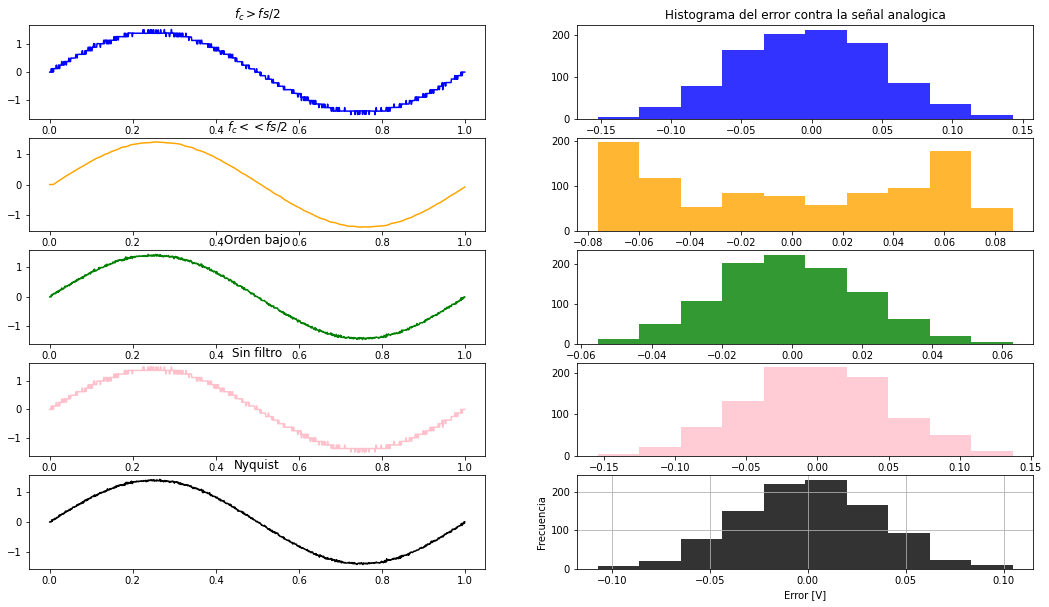

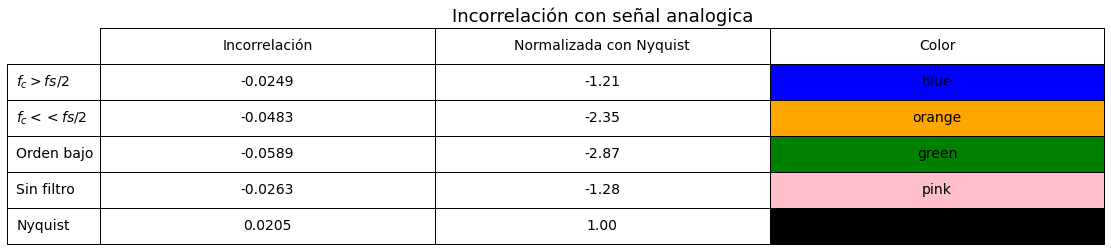

In [389]:
arr_s = [s_1, s_2, s_3, s_4, s_decimada]
arr_tt = [tt_1, tt_2, tt_3, tt_4, tt_decimada]
arr_n = [n_1, n_2, n_3, n_4, n_r]
arr_titulos = ["$f_c > fs/2$","$f_c << fs/2$","Orden bajo","Sin filtro","Nyquist"]
arr_colores = ["blue", "orange", "green", "pink", "black"]

bins = 10
fig, axs = plt.subplots(5, 2, figsize=(18, 10))
for i in range(5):
    axs[i,0].plot(arr_tt[i], arr_s[i], label='Filtrada y decimada', color=arr_colores[i])
    axs[i,0].set_title(arr_titulos[i]); plt.grid()

    axs[i,1].hist(arr_n[i], bins=bins, alpha=0.8, label="Ruido + oversampling + decimada", color=arr_colores[i])
    #axs[i,1].plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
    if(i==0):
        axs[i,1].set_title("Histograma del error contra la señal analogica")
    if(i==4):    
        axs[i,1].set_xlabel("Error [V]"); plt.ylabel("Frecuencia")
plt.show()

# INCORRELACIONES #
inc_vals = []
for i in range(5):
    corr = np.corrcoef(arr_n[i], s)[0, 1]
    inc_vals.append(corr) # Añado valor al array
inc_nyquist = inc_vals[-1]
inc_normalizados = np.divide(inc_vals, inc_nyquist)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
tabla = ax.table(
    cellText=list(zip([f"{val:.4f}" for val in inc_vals],[f"{val:.2f}" for val in inc_normalizados],arr_colores)),
    colLabels=["Incorrelación", "Normalizada con Nyquist", "Color"],
    rowLabels=arr_titulos,loc='center',cellLoc='center')
tabla.scale(1.5, 3)
for key, cell in tabla.get_celld().items():
    cell.set_fontsize(14)
for i, color in enumerate(arr_colores):
    tabla[(i + 1, 2)].set_facecolor(color)
plt.title("Incorrelación con señal analogica", fontsize=18)
plt.show()
